In [1]:
import pandas as pd
from matplotlib import rc
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from numpy import array
import seaborn as sns

2022-10-20 04:00:13.937943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-20 04:00:13.937997: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [3]:
df_colheitas = pd.read_csv('../colheitas/predictors/colheitas_cst.csv', parse_dates=['date'])
df_colheitas = df_colheitas.set_index('date')
df_colheitas = df_colheitas.groupby('cst').resample('M').sum()
df_colheitas = df_colheitas.reset_index()
df_colheitas = df_colheitas.set_index(['date'])
df_colheitas = df_colheitas.sort_values(axis=0, by=['date', 'cst'])
df_colheitas = df_colheitas.pivot_table('nr','date','cst')
df_colheitas.fillna(value=0, inplace=True)
df_colheitas = df_colheitas.rename(columns={'Coimbra':'supply_coimbra', 'Lisboa': 'supply_lisboa', 'Porto':'supply_porto'})

In [4]:
df_consumos = pd.read_csv('../consumos/predictors/consumos_cst.csv', parse_dates=['date'])
df_consumos = df_consumos.set_index('date')
df_consumos = df_consumos.groupby('cst').resample('M').sum()
df_consumos = df_consumos.reset_index()
df_consumos = df_consumos.set_index(['date'])
df_consumos = df_consumos.sort_values(axis=0, by=['date', 'cst'])
df_consumos = df_consumos.pivot_table('nr','date','cst')
df_consumos.fillna(value=0, inplace=True)
df_consumos = df_consumos.rename(columns={'Coimbra':'demand_coimbra', 'Lisboa': 'demand_lisboa', 'Porto':'demand_porto'})

In [5]:
df = pd.concat([df_colheitas, df_consumos], axis=1)

In [6]:
df.fillna(value=0, inplace=True)
df['diff_coimbra'] = df['supply_coimbra'] - df['demand_coimbra']
df['diff_lisboa'] = df['supply_lisboa'] - df['demand_lisboa']
df['diff_porto'] = df['supply_porto'] - df['demand_porto']

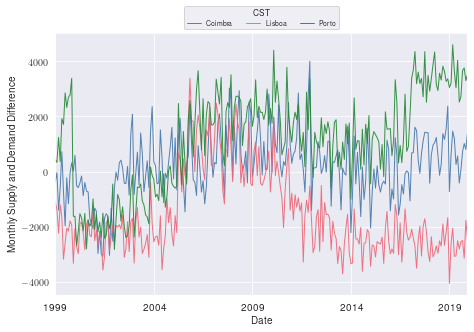

In [7]:
df[['diff_coimbra','diff_lisboa','diff_porto']].plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[0], colors[1], colors[2]], xlabel='Date', ylabel='Monthly Supply and Demand Difference')
plt.legend(['Coimbra','Lisboa', 'Porto'], title_fontsize='small', fontsize='x-small', title='CST', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
plt.tight_layout()
plt.savefig('figures/supply_demand_diff_cst_monthly.pdf', bbox_inches = "tight")

In [8]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [9]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=70, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, callbacks=[callback])
    return model 

In [10]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    #print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)      
    
    mae, rmse, smape, preds = list(), list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 1)
        pred = scaler.inverse_transform(pred)
        
        preds.extend(pred.tolist()[0])
        preds.extend(pred.tolist()[1])
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        #print(x_input, current_pred)
    
    return mae, rmse, smape, preds

In [11]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [12]:
def measure_error(actual, pred, step_in, step_out, index):
    print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [13]:
df_pred = df[222:]

In [14]:
dataset = df[['supply_coimbra','demand_coimbra']].values
dataset = df[['supply_coimbra','demand_coimbra']].astype('float32')
dataset_diff = df[['diff_coimbra']].values
dataset_diff = df[['diff_coimbra']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_diff = scaler.fit_transform(dataset_diff)
mae, rmse, smape, pred_diff_coimbra = train_predict(dataset[:216], dataset_diff[:216], dataset[216:], df[['diff_coimbra']][216:].values)

2022-10-20 04:00:18.904927: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-20 04:00:18.904973: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-20 04:00:18.905460: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
7/7 [==============================] - 3s 11ms/step - loss: 0.2350
Epoch 2/500
7/7 [==============================] - 0s 11ms/step - loss: 0.1774
Epoch 3/500
7/7 [==============================] - 0s 11ms/step - loss: 0.1160
Epoch 4/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0459
Epoch 5/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0348
Epoch 6/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0243
Epoch 7/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0255
Epoch 8/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0231
Epoch 9/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0235
Epoch 10/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0230
Epoch 11/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0231
Epoch 12/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0227
Epoch 13/500
7/7 [==============================]

7/7 [==============================] - 0s 12ms/step - loss: 0.0187
Epoch 104/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0181
Epoch 105/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0179
Epoch 106/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0182
Epoch 107/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0179
Epoch 108/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0179
Epoch 109/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0181
Epoch 110/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0181
Epoch 111/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0183
Epoch 112/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0176
Epoch 113/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0176
Epoch 114/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 115/500
7/7 [========================

7/7 [==============================] - 0s 8ms/step - loss: 0.0167
Epoch 206/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0161
Epoch 207/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0164
Epoch 208/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0165
Epoch 209/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0162
Epoch 210/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0158
Epoch 211/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0159
Epoch 212/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0162
Epoch 213/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0159
Epoch 214/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 215/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 216/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0160
Epoch 217/500
7/7 [==============================] -

7/7 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 308/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 309/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0149
Epoch 310/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0153
Epoch 311/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0158
Epoch 312/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0162
Epoch 313/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0159
Epoch 314/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 315/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0147
Epoch 316/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0147
Epoch 317/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 318/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 319/500
7/7 [==============================] - 0

7/7 [==============================] - 0s 10ms/step - loss: 0.0139
Epoch 410/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0140
Epoch 411/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 412/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0140
Epoch 413/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0140
Epoch 414/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0144
Epoch 415/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0147
Epoch 416/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 417/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 418/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0146
Epoch 419/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 420/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0141
Epoch 421/500
7/7 [==============================] -

/tmp/ipykernel_63762/360297693.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['pred_diff_coimbra'] = pred_diff_coimbra


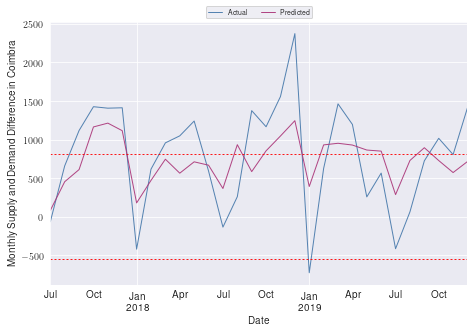

In [15]:
df_pred['pred_diff_coimbra'] = pred_diff_coimbra
df_pred[['diff_coimbra', 'pred_diff_coimbra']].pivot_table(index="date").plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[0], colors[5]], xlabel='Date', ylabel='Monthly Supply and Demand Difference in Coimbra')
plt.legend(['Actual', 'Predicted'],title_fontsize='small', fontsize='x-small', title='', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
q1 = np.quantile(df[['diff_coimbra']][:216].values, 0.25)
q2 = np.quantile(df[['diff_coimbra']][:216].values, 0.50)
q3 = np.quantile(df[['diff_coimbra']][:216].values, 0.75)
plt.axhline(y=q1, color='r', dashes=(2,2), linewidth=1, alpha=0.9)
plt.axhline(y=q3, color='r', dashes=(2,2), linewidth=1, alpha=0.9)
plt.tight_layout()
plt.savefig('figures/supply_demand_diff_monthly_pred_coimbra.pdf', bbox_inches = "tight")

In [16]:
dataset = df[['supply_lisboa','demand_lisboa']].values
dataset = df[['supply_lisboa','demand_lisboa']].astype('float32')
dataset_diff = df[['diff_lisboa']].values
dataset_diff = df[['diff_lisboa']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_diff = scaler.fit_transform(dataset_diff)
mae, rmse, smape, pred_diff_lisboa = train_predict(dataset[:216], dataset_diff[:216], dataset[216:], df[['diff_lisboa']][216:].values)

Epoch 1/500
7/7 [==============================] - 1s 7ms/step - loss: 0.1413
Epoch 2/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0903
Epoch 3/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0520
Epoch 4/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0474
Epoch 5/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0432
Epoch 6/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0451
Epoch 7/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0441
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0430
Epoch 9/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0437
Epoch 10/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0427
Epoch 11/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0428
Epoch 12/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0426
Epoch 13/500
7/7 [==============================] - 0s 7ms/st

7/7 [==============================] - 0s 7ms/step - loss: 0.0138
Epoch 105/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0136
Epoch 106/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0135
Epoch 107/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0134
Epoch 108/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0130
Epoch 109/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0131
Epoch 110/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 111/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0130
Epoch 112/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0131
Epoch 113/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0145
Epoch 114/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0129
Epoch 115/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0126
Epoch 116/500
7/7 [==============================

7/7 [==============================] - 0s 9ms/step - loss: 0.0111
Epoch 207/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0112
Epoch 208/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0112
Epoch 209/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0116
Epoch 210/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0110
Epoch 211/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0116
Epoch 212/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0112
Epoch 213/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0108
Epoch 214/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0108
Epoch 215/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0109
Epoch 216/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0108
Epoch 217/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0109
Epoch 218/500
7/7 [========================

7/7 [==============================] - 0s 11ms/step - loss: 0.0098
Epoch 309/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0100
Epoch 310/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0107
Epoch 311/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0100
Epoch 312/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 313/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0100
Epoch 314/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0105
Epoch 315/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0103
Epoch 316/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 317/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 318/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0109
Epoch 319/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0102
Epoch 320/500
7/7 [==============================

7/7 [==============================] - 0s 10ms/step - loss: 0.0091
Epoch 411/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0094
Epoch 412/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0097
Epoch 413/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0092
Epoch 414/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0100
Epoch 415/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0098
Epoch 416/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0095
Epoch 417/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0097
Epoch 418/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0103
Epoch 419/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0094
Epoch 420/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0094
Epoch 421/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0095
Epoch 422/500
7/7 [==========================

/tmp/ipykernel_63762/1752284600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['pred_diff_lisboa'] = pred_diff_lisboa


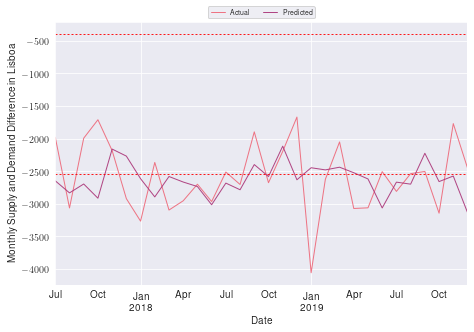

In [17]:
df_pred['pred_diff_lisboa'] = pred_diff_lisboa
df_pred[['diff_lisboa', 'pred_diff_lisboa']].pivot_table(index="date").plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[1], colors[5]], xlabel='Date', ylabel='Monthly Supply and Demand Difference in Lisboa')
plt.legend(['Actual', 'Predicted'],title_fontsize='small', fontsize='x-small', title='', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
q1 = np.quantile(df[['diff_lisboa']][:216].values, 0.25)
q2 = np.quantile(df[['diff_lisboa']][:216].values, 0.50)
q3 = np.quantile(df[['diff_lisboa']][:216].values, 0.75)
plt.axhline(y=q1, color='r', dashes=(2,2), linewidth=1, alpha=0.9)
plt.axhline(y=q3, color='r', dashes=(2,2), linewidth=1, alpha=0.9)
plt.tight_layout()
plt.savefig('figures/supply_demand_diff_monthly_pred_lisboa.pdf', bbox_inches = "tight")

In [18]:
dataset = df[['supply_porto','demand_porto']].values
dataset = df[['supply_porto','demand_porto']].astype('float32')
dataset_diff = df[['diff_porto']].values
dataset_diff = df[['diff_porto']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset_diff = scaler.fit_transform(dataset_diff)
mae, rmse, smape, pred_diff_porto = train_predict(dataset[:216], dataset_diff[:216], dataset[216:], df[['diff_porto']][216:].values)

Epoch 1/500
7/7 [==============================] - 2s 14ms/step - loss: 0.2056
Epoch 2/500
7/7 [==============================] - 0s 15ms/step - loss: 0.1320
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0688
Epoch 4/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0494
Epoch 5/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0437
Epoch 6/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0421
Epoch 7/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0422
Epoch 8/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0405
Epoch 9/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0405
Epoch 10/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0403
Epoch 11/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0399
Epoch 12/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0394
Epoch 13/500
7/7 [==============================]

7/7 [==============================] - 0s 12ms/step - loss: 0.0209
Epoch 104/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0204
Epoch 105/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0206
Epoch 106/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0194
Epoch 107/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0197
Epoch 108/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0204
Epoch 109/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0190
Epoch 110/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0188
Epoch 111/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0188
Epoch 112/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0182
Epoch 113/500
7/7 [==============================] - 0s 15ms/step - loss: 0.0180
Epoch 114/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0179
Epoch 115/500
7/7 [=======================

7/7 [==============================] - 0s 15ms/step - loss: 0.0137
Epoch 205/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0138
Epoch 206/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0135
Epoch 207/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0135
Epoch 208/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0139
Epoch 209/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0144
Epoch 210/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0152
Epoch 211/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0143
Epoch 212/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0138
Epoch 213/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0138
Epoch 214/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0134
Epoch 215/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0136
Epoch 216/500
7/7 [=======================

7/7 [==============================] - 0s 14ms/step - loss: 0.0126
Epoch 306/500
7/7 [==============================] - 0s 16ms/step - loss: 0.0133
Epoch 307/500
7/7 [==============================] - 0s 14ms/step - loss: 0.0127
Epoch 308/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0135
Epoch 309/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0144
Epoch 310/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0146
Epoch 311/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0147
Epoch 312/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0137
Epoch 313/500
7/7 [==============================] - 0s 13ms/step - loss: 0.0132
Epoch 314/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0135
Epoch 315/500
7/7 [==============================] - 0s 11ms/step - loss: 0.0131
Epoch 316/500
7/7 [==============================] - 0s 12ms/step - loss: 0.0124
Epoch 317/500
7/7 [=======================

7/7 [==============================] - 0s 22ms/step - loss: 0.0117
Epoch 407/500
7/7 [==============================] - 0s 21ms/step - loss: 0.0120
Epoch 408/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0121
Epoch 409/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0121
Epoch 410/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0128
Epoch 411/500
7/7 [==============================] - 0s 24ms/step - loss: 0.0122
Epoch 412/500
7/7 [==============================] - 0s 19ms/step - loss: 0.0120
Epoch 413/500
7/7 [==============================] - 0s 18ms/step - loss: 0.0118
Epoch 414/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0122
Epoch 415/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0122
Epoch 416/500
7/7 [==============================] - 0s 20ms/step - loss: 0.0131
Epoch 417/500
7/7 [==============================] - 0s 17ms/step - loss: 0.0125
Epoch 418/500
7/7 [=======================

/tmp/ipykernel_63762/2784466215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['pred_diff_porto'] = pred_diff_porto


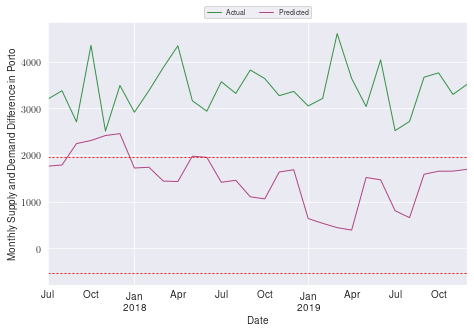

In [19]:
df_pred['pred_diff_porto'] = pred_diff_porto
df_pred[['diff_porto', 'pred_diff_porto']].pivot_table(index="date").plot(figsize=(17*cm,12*cm), linewidth=1, alpha=0.9, color=[colors[2], colors[5]], xlabel='Date', ylabel='Monthly Supply and Demand Difference in Porto')
plt.legend(['Actual', 'Predicted'],title_fontsize='small', fontsize='x-small', title='', loc="lower center", bbox_to_anchor=(0.5,1), ncol=5)
q1 = np.quantile(df[['diff_porto']][:216].values, 0.25)
q2 = np.quantile(df[['diff_porto']][:216].values, 0.50)
q3 = np.quantile(df[['diff_porto']][:216].values, 0.75)
plt.axhline(y=q1, color='r', dashes=(2,2), linewidth=1, alpha=0.9)
plt.axhline(y=q3, color='r', dashes=(2,2), linewidth=1, alpha=0.9)
plt.tight_layout()
plt.savefig('figures/supply_demand_diff_monthly_pred_porto.pdf', bbox_inches = "tight")